In [1]:
import pandas as pd
import numpy as np

# FOREST HEALTH UK #

### Uploading the data set

In [2]:

df = pd.read_csv('/Users/sandra/Desktop/Capstone/Final_clean_data_modeling.csv')
df.head()

,year,plot_type,assessment_date,assessment_type,plot_number,subplot,tree_number,species,local_crown_density,diameter_mm,...,address,country,ammonia,nitrous_oxide,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature
0,1995,OK,1995-07-31,I,1,N,1,OK,15.0,875.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
1,1995,OK,1995-07-31,I,1,N,2,OK,25.0,517.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
2,1995,OK,1995-07-31,I,1,N,3,OK,15.0,673.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
3,1995,OK,1995-07-31,I,1,N,4,OK,10.0,621.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07
4,1995,OK,1995-07-31,I,1,N,5,OK,25.0,1020.0,...,"Farnham Road, Forest Lodge, Binsted, Frith End...",England,96.000094,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07


In [3]:
df.shape

(46929, 63)

In [4]:
df.local_crown_density.unique()

array([15., 25., 10., 30., 55., 40., 60., 45., 20.,  5., 50., 75., 70.,
       35.,  0., 65., 80., 90., 85., 99., 95.])

In [5]:
#creating age
df['age'] = df['year'] - df['planting_year'] 

### Creating binary target variable crown density class

In [6]:
#creating mean of local crown density reduction based on tree species
mean_col = df.groupby(['year', 'species'])['local_crown_density'].mean() # don't reset the index!
df = df.set_index(['year', 'species']) # make the same index here
df['mean_col'] = mean_col
df = df.reset_index() # to take the hierarchical index off again

In [7]:
crown_mean = np.mean(df['mean_col'])
crown_mean

21.227172963409487

In [8]:
df['Crown_density_class'] = [1 if i > crown_mean else 0 for i in df.local_crown_density]
df.head()

,year,species,plot_type,assessment_date,assessment_type,plot_number,subplot,tree_number,local_crown_density,diameter_mm,...,nitrous_oxide,sulphur_dioxide,volatile_organic_compounds,particulate_matter_10,particulate_matter_25,ann_rainfall,ann_temperature,age,mean_col,Crown_density_class
0,1995,OK,OK,1995-07-31,I,1,N,1,15.0,875.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
1,1995,OK,OK,1995-07-31,I,1,N,2,25.0,517.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,1
2,1995,OK,OK,1995-07-31,I,1,N,3,15.0,673.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
3,1995,OK,OK,1995-07-31,I,1,N,4,10.0,621.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,0
4,1995,OK,OK,1995-07-31,I,1,N,5,25.0,1020.0,...,86.45724,38.979309,93.290781,41.82557,34.350562,751.8,10.07,175,17.298236,1


In [9]:
#saving clean data to csv
df.to_csv('Final_clean_new_data.csv', index=False)

In [10]:
from scipy import stats
import statsmodels.api as sm
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# MODELING

### Baseline

In [12]:
df_copy = df.copy()

In [13]:
#baseline accuracy
df.Crown_density_class.value_counts(normalize=True).max()

0.6208953951714292

In [14]:
#classification target
y = df_copy.pop('Crown_density_class')

In [15]:
y.shape

(46929,)

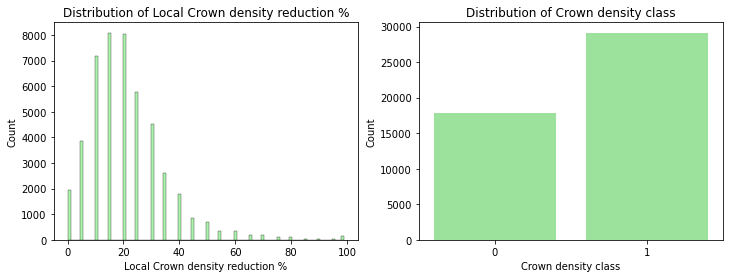

In [16]:
fig, ax = plt.subplots(ncols=2,figsize=(12,4))
sns.histplot(data = df.local_crown_density, ax=ax[0], color='lightgreen')
sns.barplot(x=['0','1'], y=[df.Crown_density_class.value_counts()[1],df.Crown_density_class.value_counts()[0]], ax=ax[1],color='lightgreen')
ax[1].set(xlabel='Crown density class')
ax[1].set(ylabel='Count')
ax[0].set(xlabel="Local Crown density reduction %")
ax[0].set_title('Distribution of Local Crown density reduction %')
ax[1].set_title('Distribution of Crown density class')
plt.show()

### Creating first set of predictors

In [17]:
X = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall']]

In [18]:
X = pd.get_dummies(X,columns = [
       'defoliation_type',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X.columns

Index(['diameter_mm', 'height_cm', 'ammonia', 'nitrous_oxide',
       'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'defoliation_type_1.0', 'defoliation_type_2.0',
       'defoliation_type_3.0', 'defoliation_type_4.0', 'defoliation_type_5.0',
       'defoliation_type_6.0', 'defoliation_type_7.0', 'defoliation_type_8.0',
       'overall_discolouration_1.0', 'overall_discolouration_2.0',
       'overall_discolouration_3.0', 'overall_discolouration_4.0',
       'damage_butt_stem_1.0', 'damage_game_1.0', 'damage_game_2.0',
       'damage_insect_1.0', 'damage_insect_2.0', 'damage_insect_3.0',
       'damage_insect_4.0', 'damage_fungal_1.0', 'damage_fungal_2.0',
       'damage_fungal_3.0', 'damage_fungal_4.0', 'damage_abiotic_1.0',
       'damage_man_1.0', 'damage_fire_1.0', 'damage_other_1.0',
       'shoot_death_branch_1.0', 'shoot_death_branch_2.0',
       'shoot_death_branch_3.0', 'shoot

In [19]:
X.shape

(46929, 43)

### Creating second set of predictors

In [20]:
X2 = df_copy[[ 'diameter_mm', 'height_cm', 'shoot_death_branch',
        'defoliation_type','broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
'broadleaf_dieback_extend_per',
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'ammonia', 'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds', 'particulate_matter_10', 'particulate_matter_25','ann_temperature',       
                       
'ann_rainfall', 'latitude','age' ]]

In [21]:
X2 = pd.get_dummies(X2,columns = [
       'defoliation_type', 'broadleaf_dieback_type', 'leaf_browning',                 
'leaf_yellowing',      
       'overall_discolouration', 
        'damage_butt_stem', 'damage_game',
       'damage_insect', 'damage_fungal', 'damage_abiotic', 'damage_man',
       'damage_fire', 'damage_other', 'shoot_death_branch'
       ], drop_first = True)
X2.columns

Index(['diameter_mm', 'height_cm', 'broadleaf_dieback_extend_per', 'ammonia',
       'nitrous_oxide', 'sulphur_dioxide', 'volatile_organic_compounds',
       'particulate_matter_10', 'particulate_matter_25', 'ann_temperature',
       'ann_rainfall', 'latitude', 'age', 'defoliation_type_1.0',
       'defoliation_type_2.0', 'defoliation_type_3.0', 'defoliation_type_4.0',
       'defoliation_type_5.0', 'defoliation_type_6.0', 'defoliation_type_7.0',
       'defoliation_type_8.0', 'broadleaf_dieback_type_1.0',
       'broadleaf_dieback_type_2.0', 'broadleaf_dieback_type_3.0',
       'broadleaf_dieback_type_4.0', 'broadleaf_dieback_type_5.0',
       'broadleaf_dieback_type_6.0', 'leaf_browning_1.0', 'leaf_browning_2.0',
       'leaf_browning_3.0', 'leaf_browning_4.0', 'leaf_browning_5.0',
       'leaf_yellowing_1.0', 'leaf_yellowing_2.0', 'leaf_yellowing_3.0',
       'leaf_yellowing_4.0', 'leaf_yellowing_5.0',
       'overall_discolouration_1.0', 'overall_discolouration_2.0',
       'overal

In [22]:
X2.shape

(46929, 62)

### Creating third set of predictors

In [23]:
x3 = df_copy

In [24]:
x3 = pd.get_dummies(x3, drop_first = True)
x3.columns

Index(['year', 'plot_number', 'tree_number', 'local_crown_density',
       'diameter_mm', 'height_cm', 'tree_dominance_class',
       'canopy_closure_class', 'defoliation_type', 'broadleaf_dieback_type',
       ...
       'address_Woodditton, Ditton Green, Cambridgeshire, East of England, England, United Kingdom',
       'address_Woodlands, Honey Hill, Blean, Canterbury, Kent, South East England, England, CT2 9JW, United Kingdom',
       'address_Woodside Court, Dalbeattie, Dumfries and Galloway, Scotland, DG5 4NX, United Kingdom',
       'address_Wytham Woods, Middle Ride, Wytham, Vale of White Horse, Oxfordshire, South East England, England, OX2 8QQ, United Kingdom',
       'address_Yardley Hastings, West Northamptonshire, East Midlands, England, United Kingdom',
       'address_Ynys Hir Hide, A487, Ysgubor-y-coed, Ffwrnais / Furnace, Ceredigion, Cymru / Wales, SY20 8ND, United Kingdom',
       'address_Ystradfellte, Pontneddfechan, Powys, Cymru / Wales, SA11 5UP, United Kingdom',
  

### Applying the models

In [25]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

# MODELING WITHOUT TREATING CLASS IMBALANCE 

### Model set 1 - X

In [27]:
#models to be used
models = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]
#setting target and predictors
#y = df.Crown_density_class
X = X
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y,test_size=0.2,
     random_state=1)

print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print('train score:', train_score)
    test_score = model.score(X_test, y_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X_train, y_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X_train, y_train, cv=5, n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y_pred = model.predict(X_test)
    print()
    cm = docm(y_test, y_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y_test, y_pred))
    print()
    res.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.8004954319047493
test score: 0.707969316002557
cross val score: [0.70595286 0.69862831 0.71367692 0.70791156 0.70618007]
cross val mean score: 0.7064699451760711

Confusion matrix
    p_0   p_1
0  4675  1153
1  1588  1970

Classification report
              precision    recall  f1-score   support

           0       0.75      0.80      0.77      5828
           1       0.63      0.55      0.59      3558

    accuracy                           0.71      9386
   macro avg       0.69      0.68      0.68      9386
weighted avg       0.70      0.71      0.70      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 0.7117438670324694
test score: 0.7206477732793523
cross val score: [0.71727261 0.70502064 0.71607404 0.70471497 0.71656899]
cross val mean score: 0.7119302512708422

Confusion matrix
    p_0   p_1
0  4856   972
1  1650  1908

Classification report
              precisi

### Model set 2 - X2

In [28]:
models2 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
X2 = X2


#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, stratify = y, test_size=0.2,
     random_state=1)


print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X2_train = pd.DataFrame(scaler.fit_transform(X2_train), columns=X2.columns)
X2_test = pd.DataFrame(scaler.transform(X2_test), columns=X2.columns)

res2 = []

for model in models2:
    print(model)
    print()
    model.fit(X2_train, y2_train)
    train_score = model.score(X2_train, y2_train)
    print('train score:', train_score)
    test_score = model.score(X2_test, y2_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X2_train, y2_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X2_train, y2_train, cv=5, n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y2_pred = model.predict(X2_test)
    print()
    cm = docm(y2_test, y2_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y2_test, y2_pred))
    print()
    res2.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.8154649335428709
test score: 0.7272533560622203
cross val score: [0.7198029  0.7158077  0.72552936 0.72123069 0.7241609 ]
cross val mean score: 0.7213063095374167

Confusion matrix
    p_0   p_1
0  4770  1058
1  1502  2056

Classification report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5828
           1       0.66      0.58      0.62      3558

    accuracy                           0.73      9386
   macro avg       0.71      0.70      0.70      9386
weighted avg       0.72      0.73      0.72      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 0.7365953706416642
test score: 0.7384402301299808
cross val score: [0.7339193  0.72859236 0.74217606 0.7317528  0.73681406]
cross val mean score: 0.734650914019497

Confusion matrix
    p_0   p_1
0  4956   872
1  1583  1975

Classification report
              precisi

### Model set 3 - X3

In [29]:
models3 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
x3 = x3

#train test split
x3_train, x3_test, y3_train, y3_test = train_test_split(
    x3, y, stratify = y, test_size=0.2,
     random_state=1)

print("Models:")
#standarizing with standard scaler
scaler = StandardScaler()
x3_train = pd.DataFrame(scaler.fit_transform(x3_train), columns=x3.columns)
x3_test = pd.DataFrame(scaler.transform(x3_test), columns=x3.columns)

res3 = []

for model in models3:
    print(model)
    print()
    model.fit(x3_train, y3_train)
    train_score = model.score(x3_train, y3_train)
    print('train score:', train_score)
    test_score = model.score(x3_test, y3_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, x3_train, y3_train, cv=5, n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, x3_train, y3_train, cv=5, n_jobs =3).mean()
    print('cross val mean score:', cross_val_mean)
    y3_pred = model.predict(x3_test)
    print()
    cm = docm(y3_test, y3_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y3_test, y3_pred))
    print()
    res3.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Models:
KNeighborsClassifier()

train score: 0.8239884931944703
test score: 0.742914979757085
cross val score: [0.73471834 0.72952457 0.73312026 0.72429409 0.73708045]
cross val mean score: 0.7317475396067075

Confusion matrix
    p_0   p_1
0  4995   833
1  1580  1978

Classification report
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5828
           1       0.70      0.56      0.62      3558

    accuracy                           0.74      9386
   macro avg       0.73      0.71      0.71      9386
weighted avg       0.74      0.74      0.74      9386



------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 1.0
test score: 0.994566375452802
cross val score: [0.9909442  0.9929418  0.99001199 0.99280767 0.99214172]
cross val mean score: 0.9917694752799926

Confusion matrix
    p_0   p_1
0  5811    17
1    34  3524

Classification report
              precision    recall  f1

# MODELING - APPLYING SMOTE OVERSAMPLING 

In [30]:
from collections import Counter

### Model set 4 - X

In [31]:
#models to be used
models4 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]
#setting target and predictors
#y = df.Crown_density_class
X4 = X
#train test split
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y, stratify = y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y4_train)
print('Class balance before SMOTE',counter)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X4_train,y4_train = oversample.fit_resample(X4_train, y4_train)

#counting y after SMOTE
counter = Counter(y4_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X4_train = pd.DataFrame(scaler.fit_transform(X4_train), columns=X4.columns)
X4_test = pd.DataFrame(scaler.transform(X4_test), columns=X4.columns)

res4 = []

for model in models4:
    print(model)
    print()
    model.fit(X4_train, y4_train)
    train_score = model.score(X4_train, y4_train)
    print('train score:', train_score)
    test_score = model.score(X4_test, y4_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X4_train, y4_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X4_train, y4_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y4_pred = model.predict(X4_test)
    print()
    cm = docm(y4_test, y4_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y4_test, y4_pred))
    res4.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23310, 1: 14233})
Class balance after SMOTE Counter({0: 23310, 1: 23310})


Models:
KNeighborsClassifier()

train score: 0.804011154011154
test score: 0.6694012358832303
cross val score: [0.64425139 0.65100815 0.65079365 0.75804376 0.76555127]
cross val mean score: 0.693929643929644

Confusion matrix
    p_0   p_1
0  4210  1618
1  1485  2073

Classification report
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      5828
           1       0.56      0.58      0.57      3558

    accuracy                           0.67      9386
   macro avg       0.65      0.65      0.65      9386
weighted avg       0.67      0.67      0.67      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 0.6958172458172458
test score: 0.6461751544854037
cross val score: [0.61389961 0.61936937 0.61679537 0.7502145  0.75664951]
cross val mean score: 0.67138567

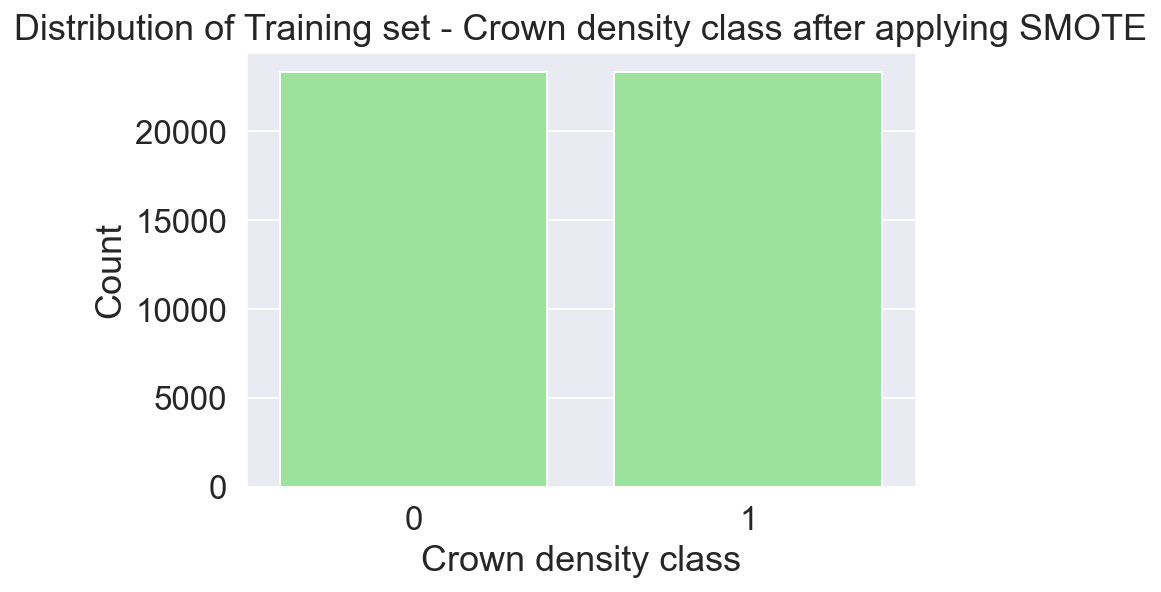

In [32]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Model set 5  - X2

In [33]:
models5 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
X5 = X2


#train test split
X5_train, X5_test, y5_train, y5_test = train_test_split(
    X5, y, stratify = y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y5_train)
print('Class balance before SMOTE',counter)


#applying SMOTE to avoid class imbalance
oversample = SMOTE()
X5_train,y5_train = oversample.fit_resample(X5_train, y5_train)

#counting y after SMOTE
counter = Counter(y5_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
X5_train = pd.DataFrame(scaler.fit_transform(X5_train), columns=X5.columns)
X5_test = pd.DataFrame(scaler.transform(X5_test), columns=X5.columns)

res5 = []

for model in models5:
    print(model)
    print()
    model.fit(X5_train, y5_train)
    train_score = model.score(X5_train, y5_train)
    print('train score:', train_score)
    test_score = model.score(X5_test, y5_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, X5_train, y5_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, X5_train, y5_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y5_pred = model.predict(X5_test)
    print()
    print()
    cm = docm(y5_test, y5_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y5_test, y5_pred))
    res5.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23310, 1: 14233})
Class balance after SMOTE Counter({0: 23310, 1: 23310})


Models:
KNeighborsClassifier()

train score: 0.8291505791505791
test score: 0.7058384828467931
cross val score: [0.67288717 0.67556843 0.68393393 0.7962248  0.7972973 ]
cross val mean score: 0.7251823251823252


Confusion matrix
    p_0   p_1
0  4461  1367
1  1394  2164

Classification report
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      5828
           1       0.61      0.61      0.61      3558

    accuracy                           0.71      9386
   macro avg       0.69      0.69      0.69      9386
weighted avg       0.71      0.71      0.71      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 0.7375160875160875
test score: 0.6998721500106542
cross val score: [0.65873016 0.66924067 0.67503218 0.79493779 0.78453453]
cross val mean score: 0.71649

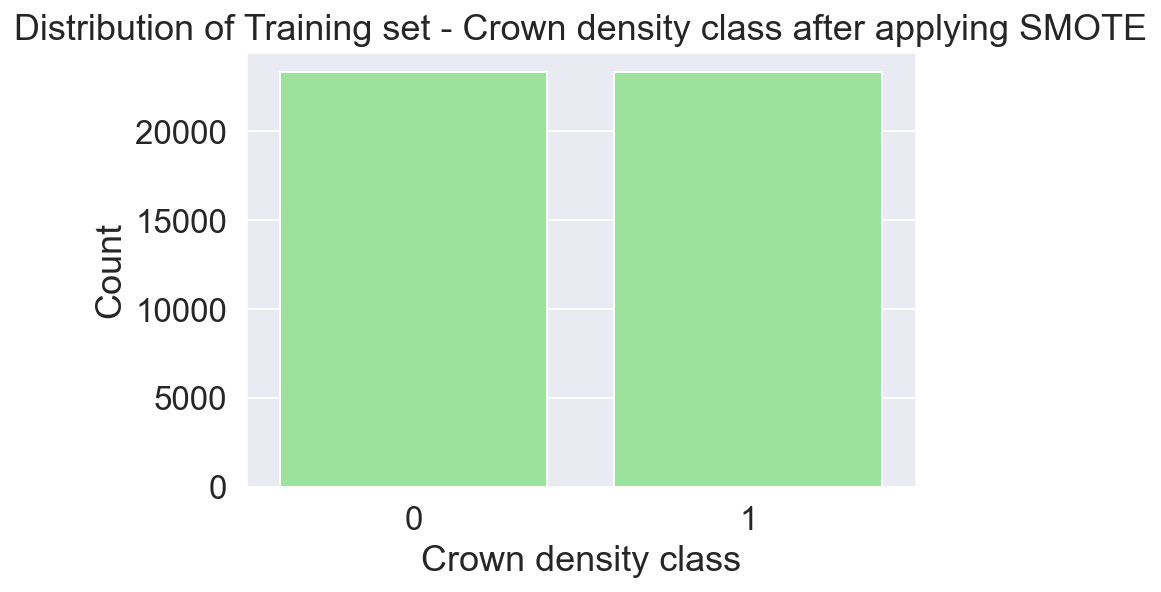

In [34]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Model set 6 - X3

In [35]:
models6 = [KNeighborsClassifier(),
          LogisticRegression(max_iter=1000),
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

#target and predictors
#y = df.Crown_density_class
x6 = x3

#train test split
x6_train, x6_test, y6_train, y6_test = train_test_split(
    x6, y, stratify = y, test_size=0.2,
     random_state=1)

#counting y before SMOTE
counter = Counter(y6_train)
print('Class balance before SMOTE',counter)

#applying SMOTE to avoid class imbalance
oversample = SMOTE()
x6_train,y6_train = oversample.fit_resample(x6_train, y6_train)

#counting y after SMOTE
counter = Counter(y6_train)
print('Class balance after SMOTE',counter)
print()
print()
print('Models:')
#standarizing with standard scaler
scaler = StandardScaler()
x6_train = pd.DataFrame(scaler.fit_transform(x6_train), columns=x6.columns)
x6_test = pd.DataFrame(scaler.transform(x6_test), columns=x6.columns)

res6 = []

for model in models6:
    print(model)
    print()
    model.fit(x6_train, y6_train)
    train_score = model.score(x6_train, y6_train)
    print('train score:', train_score)
    test_score = model.score(x6_test, y6_test)
    print('test score:', test_score)
    cross_val = cross_val_score(model, x6_train, y6_train, cv=5,n_jobs=3)
    print('cross val score:', cross_val)
    cross_val_mean = cross_val_score(model, x6_train, y6_train, cv=5,n_jobs=3).mean()
    print('cross val mean score:', cross_val_mean)
    y6_pred = model.predict(x6_test)
    print()
    cm = docm(y6_test, y6_pred)
    print('Confusion matrix')
    print(cm)
    print()
    print('Classification report')
    print(classification_report(y6_test, y6_pred))
    res6.append([model,train_score, test_score,cross_val, cross_val_mean])
    print()
    print('-'*60)
    print()

Class balance before SMOTE Counter({0: 23310, 1: 14233})
Class balance after SMOTE Counter({0: 23310, 1: 23310})


Models:
KNeighborsClassifier()

train score: 0.8226297726297727
test score: 0.6982740251438312
cross val score: [0.68876019 0.69594595 0.7007722  0.77992278 0.79804805]
cross val mean score: 0.7326898326898327

Confusion matrix
    p_0   p_1
0  4021  1807
1  1025  2533

Classification report
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      5828
           1       0.58      0.71      0.64      3558

    accuracy                           0.70      9386
   macro avg       0.69      0.70      0.69      9386
weighted avg       0.72      0.70      0.70      9386


------------------------------------------------------------

LogisticRegression(max_iter=1000)

train score: 1.0
test score: 0.9915832090347326
cross val score: [0.98788074 0.98959674 0.98798799 0.99420849 0.99538825]
cross val mean score: 0.991012441012441

Conf

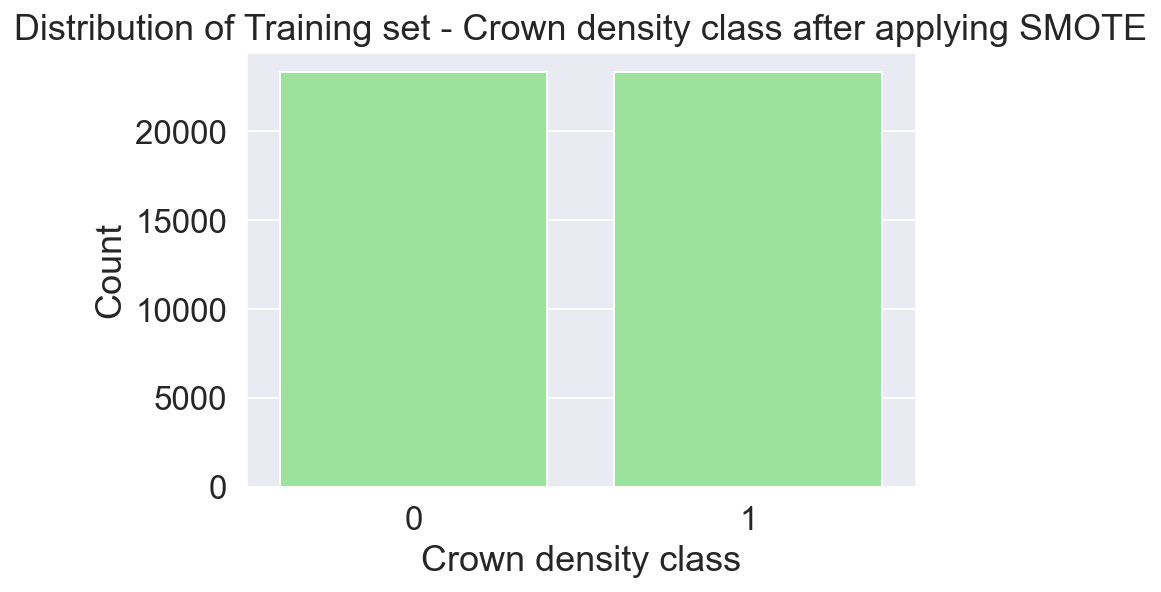

In [36]:
fig, ax = plt.subplots(ncols=1,figsize=(6,4))
sns.barplot(x=['0','1'], y=[y4_train.value_counts()[1],y4_train.value_counts()[0]], ax=ax,color='lightgreen')
ax.set(xlabel='Crown density class')
ax.set(ylabel='Count')
ax.set_title('Distribution of Training set - Crown density class after applying SMOTE')
plt.show();

### Applying Grid Search CV on the best performing model across 3 model sets

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
model = LogisticRegression(max_iter=1000)
list(model.get_params().keys())

['C',
 'class_weight',
 'dual',
 'fit_intercept',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_jobs',
 'penalty',
 'random_state',
 'solver',
 'tol',
 'verbose',
 'warm_start']

In [39]:
model = LogisticRegression()
params = {'C': np.logspace(-4, 4, 10),
          'max_iter': [1000],
          'penalty': ['l2'],
          'fit_intercept': [True, False]}


gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  return_train_score=True)

gs.fit(X5_train, y5_train)

# extract the grid search results

print('Best Parameters:')
print(gs.best_params_)
print('Best estimator C:')
print(gs.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs.best_score_)
print('Best estimator score on the full training set:')
print(gs.score(X5_train, y5_train))
print('Best estimator score on the test set:')
print(gs.score(X5_test, y5_test))
print('Best estimator coefficients:')
print(gs.best_estimator_.coef_)

Best Parameters:
{'C': 2.782559402207126, 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2'}
Best estimator C:
2.782559402207126
Best estimator mean cross validated training score:
0.7164950664950664
Best estimator score on the full training set:
0.7372157872157872
Best estimator score on the test set:
0.6990198167483486
Best estimator coefficients:
[[-0.37967189  0.00510582  1.33141255  0.15846197 -3.1650342   2.01499364
   0.38119059 -1.31028403  1.39858665 -0.62228761 -0.4042506  -0.24360638
   0.29981708 -0.31078845 -0.55673058 -0.14090714  0.12828821  0.05555774
  -0.18890459  0.04762913  0.02428595 -0.1155093  -0.10130984 -0.07438024
  -0.01541644 -0.2233299  -1.01931074 -0.11309514 -0.1820968  -0.14412519
   0.33054803 -1.01931074 -0.06934154 -0.07021695 -0.0539988  -0.15614176
  -1.01931074 -0.04503297  0.10361969  0.12785259  0.44334219 -0.03564959
   0.00964485  0.07641609 -0.49916489 -0.41308153 -0.25820627 -0.04408475
  -0.08650676 -0.07795543 -0.0714989   0.01134325

In [40]:
pd.DataFrame(gs.cv_results_).sort_values(by=['mean_test_score', 'std_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_fit_intercept,param_max_iter,param_penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
10,0.598205,0.072124,0.002624,0.000067,2.782559,True,1000,l2,"{'C': 2.782559402207126, 'fit_intercept': True...",0.658945,...,0.716495,0.059782,1,0.756033,0.753486,0.752011,0.721096,0.720694,0.740664,0.016193
8,0.434329,0.065771,0.002687,0.000087,0.359381,True,1000,l2,"{'C': 0.3593813663804626, 'fit_intercept': Tru...",0.657872,...,0.716452,0.060371,2,0.755899,0.753378,0.751475,0.721069,0.720694,0.740503,0.016083
6,0.264222,0.013530,0.002707,0.000112,0.046416,True,1000,l2,"{'C': 0.046415888336127774, 'fit_intercept': T...",0.657014,...,0.716431,0.061685,3,0.754665,0.752413,0.751314,0.720533,0.720533,0.739892,0.015843
12,0.838925,0.052582,0.002961,0.000432,21.544347,True,1000,l2,"{'C': 21.54434690031882, 'fit_intercept': True...",0.658730,...,0.716431,0.059659,4,0.756194,0.753512,0.752011,0.721016,0.720667,0.740680,0.016254
14,0.380622,0.021379,0.002883,0.000357,166.810054,True,1000,l2,"{'C': 166.81005372000558, 'fit_intercept': Tru...",0.658623,...,0.716409,0.059680,5,0.756194,0.753566,0.751931,0.721016,0.720855,0.740712,0.016205
18,0.392429,0.049579,0.002761,0.000113,10000.0,True,1000,l2,"{'C': 10000.0, 'fit_intercept': True, 'max_ite...",0.658730,...,0.716409,0.059676,5,0.756167,0.753593,0.751931,0.721042,0.720721,0.740691,0.016231
4,0.154339,0.012033,0.002876,0.000344,0.005995,True,1000,l2,"{'C': 0.005994842503189409, 'fit_intercept': T...",0.657443,...,0.716388,0.062562,7,0.753968,0.751448,0.751046,0.719032,0.718978,0.738894,0.016271
16,0.421527,0.050718,0.002761,0.000069,1291.549665,True,1000,l2,"{'C': 1291.5496650148827, 'fit_intercept': Tru...",0.658623,...,0.716366,0.059672,8,0.756086,0.753593,0.751957,0.721042,0.720613,0.740659,0.016245
11,0.379314,0.015356,0.002725,0.000062,2.782559,False,1000,l2,"{'C': 2.782559402207126, 'fit_intercept': Fals...",0.657014,...,0.713256,0.058749,9,0.757052,0.754397,0.752923,0.719514,0.719836,0.740744,0.017254
13,0.413928,0.042329,0.002896,0.000269,21.544347,False,1000,l2,"{'C': 21.54434690031882, 'fit_intercept': Fals...",0.657336,...,0.713256,0.058703,10,0.757132,0.754907,0.752842,0.719219,0.720211,0.740862,0.017323


In [41]:
best_model = LogisticRegression(C = 0.005994842503189409, fit_intercept = True, penalty = 'l2', max_iter=1000)
best_model.fit(X5_train, y5_train)
test_score = best_model.score(X5_test, y5_test)
train_score = best_model.score(X5_train, y5_train)
print('test score:', test_score)
print('train score', train_score)

test score: 0.6942254421478798
train score 0.735070785070785


In [43]:
predictions = best_model.predict(X5_test)

### Model Evaluation

In [44]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import scikitplot as skplt

In [45]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [46]:
df_coef = pd.DataFrame(best_model.coef_.T, index=X5_train.columns,
                       columns=['importance'])
#  values of the coefficients
df_coef.sort_values(by = 'importance', ascending = False)

,importance
broadleaf_dieback_extend_per,1.135693
age,0.272097
overall_discolouration_4.0,0.180970
ammonia,0.163977
defoliation_type_4.0,0.130983
shoot_death_branch_5.0,0.110388
overall_discolouration_3.0,0.108772
overall_discolouration_2.0,0.086553
shoot_death_branch_4.0,0.075169
sulphur_dioxide,0.061174


In [80]:
df_coef['coef_abs'] = df_coef.importance.abs()
df_coef.sort_values(by='importance')

,importance,coef_abs
shoot_death_branch_6.0,-0.686286,0.686286
defoliation_type_2.0,-0.553778,0.553778
damage_insect_1.0,-0.486258,0.486258
damage_insect_2.0,-0.402182,0.402182
particulate_matter_10,-0.388707,0.388707
diameter_mm,-0.350366,0.350366
ann_temperature,-0.311819,0.311819
defoliation_type_1.0,-0.303138,0.303138
damage_insect_3.0,-0.257215,0.257215
leaf_yellowing_5.0,-0.235011,0.235011


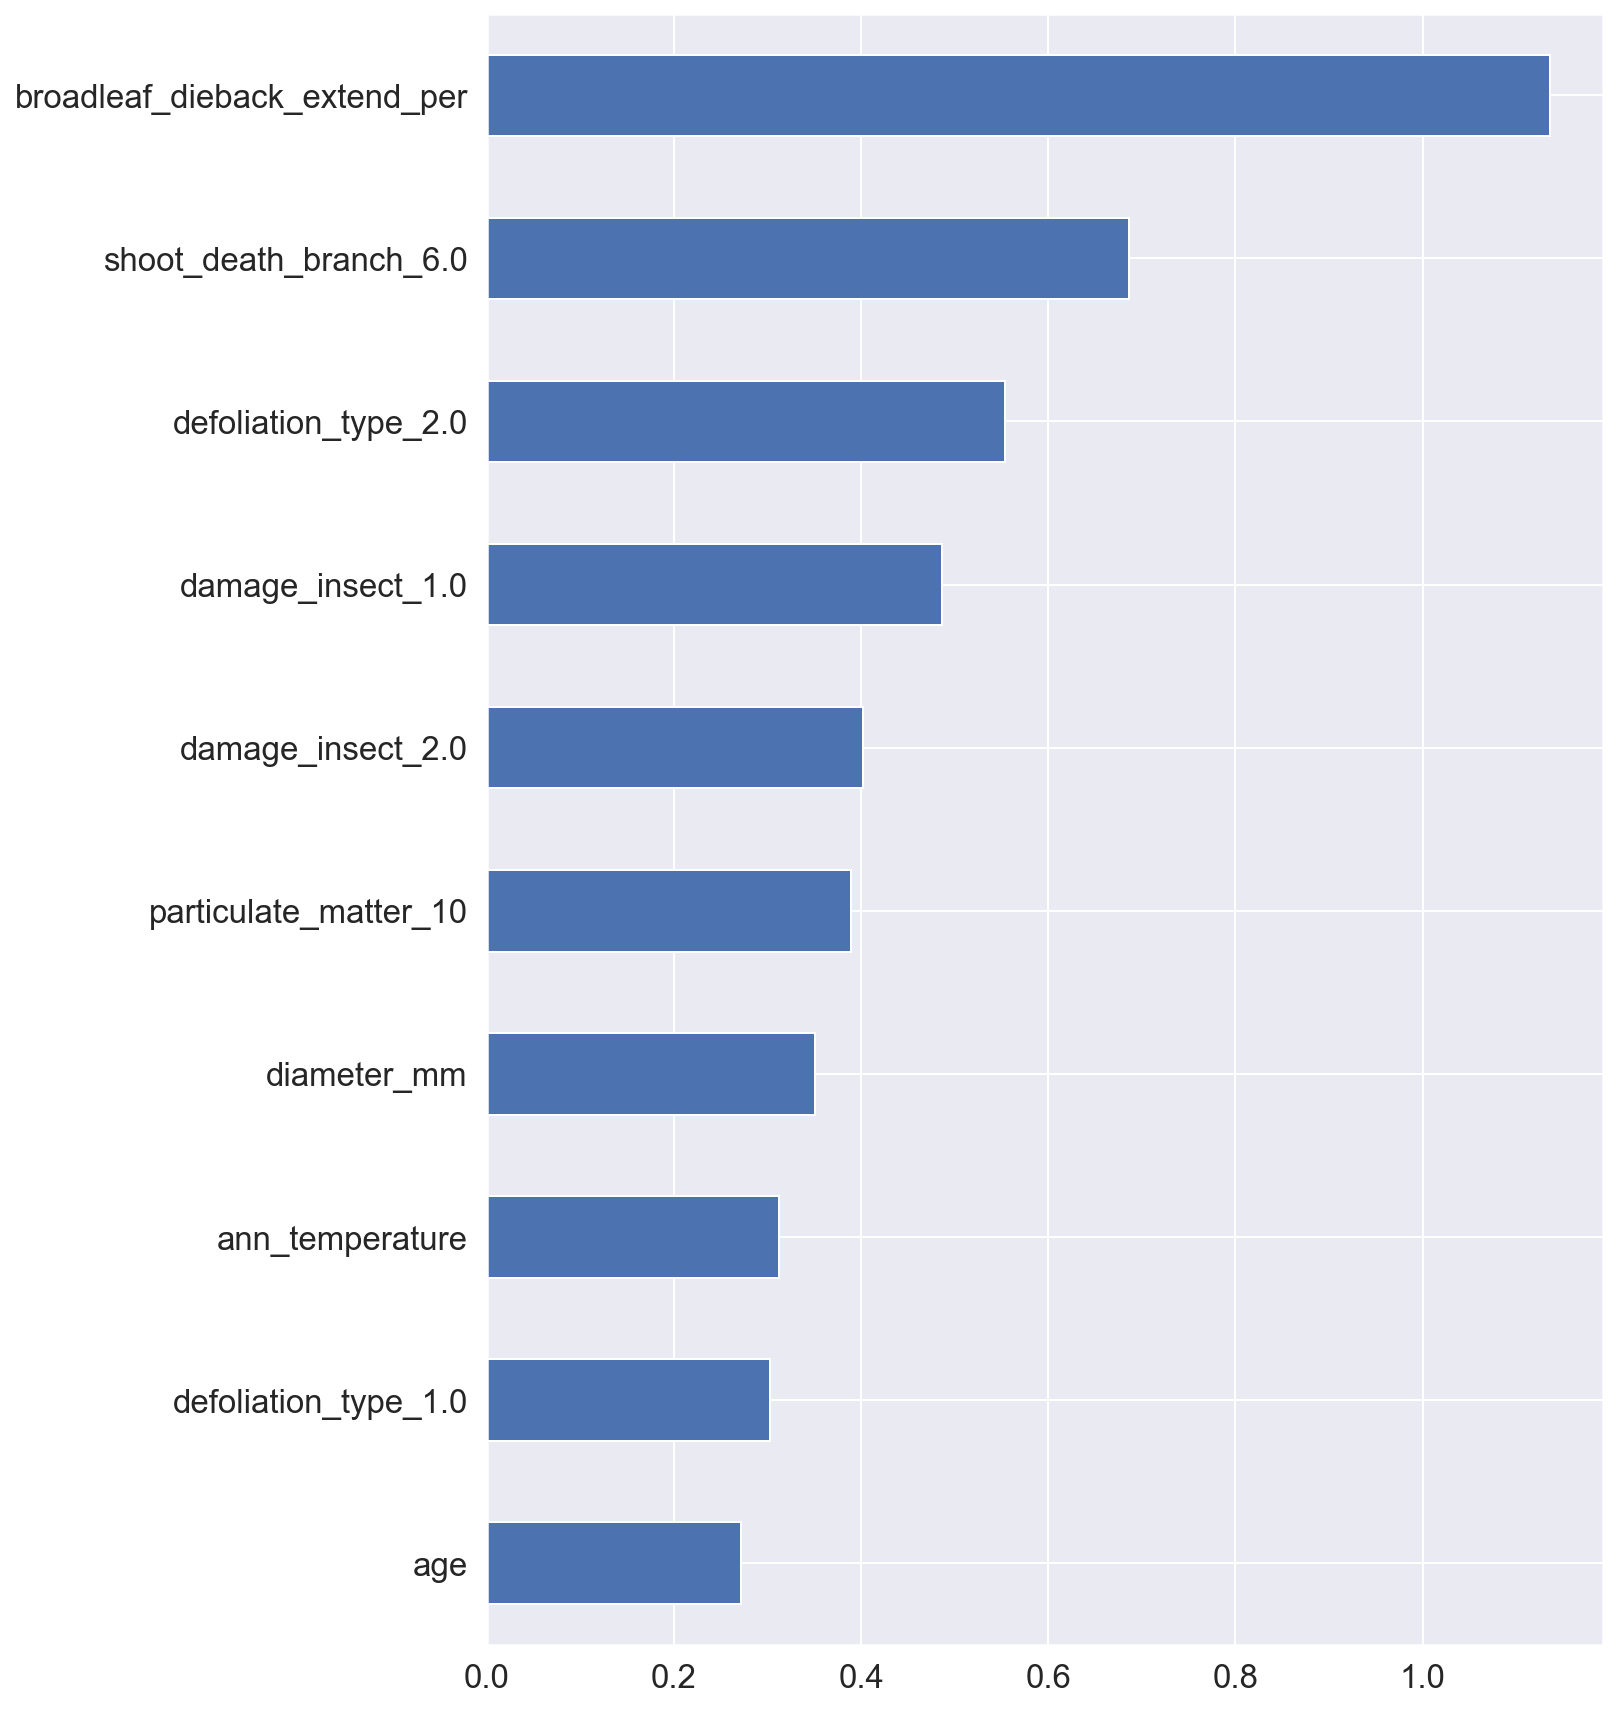

In [88]:
df_coef['coef_abs'][df_coef['coef_abs']> 0.26].sort_values().plot(kind='barh', figsize=(10, 15));

In [49]:
predictions = best_model.predict(X5_test)
confusion = confusion_matrix(y5_test, predictions, labels=[1, 0])
pd.DataFrame(confusion,
             columns=['predicted_tree_deterioration', 'predicted_healthy_tree'],
             index=['True_tree_deterioration', 'True_healthy_tree'])

,predicted_tree_deterioration,predicted_healthy_tree
True_tree_deterioration,2124,1434
True_healthy_tree,1436,4392


The classification matrix resulted in:
* 2124 true positive predictions ->classifier correct, deteriorating tree predicted as deteriorating
* 4392 true negative predictions ->classifier correct, healthy tree predicted as healthy
* 1436 false positive predictions->classifier incorrect, healthy tree predicted as deteriorating
* 1434 false negative predictions>classifier incorrect, deteriorating tree predicted as healthy

The matrix is very useful in checking performance of the model. It helps us gain an insight into how correct our predictions were and how they hold up against the actual values.


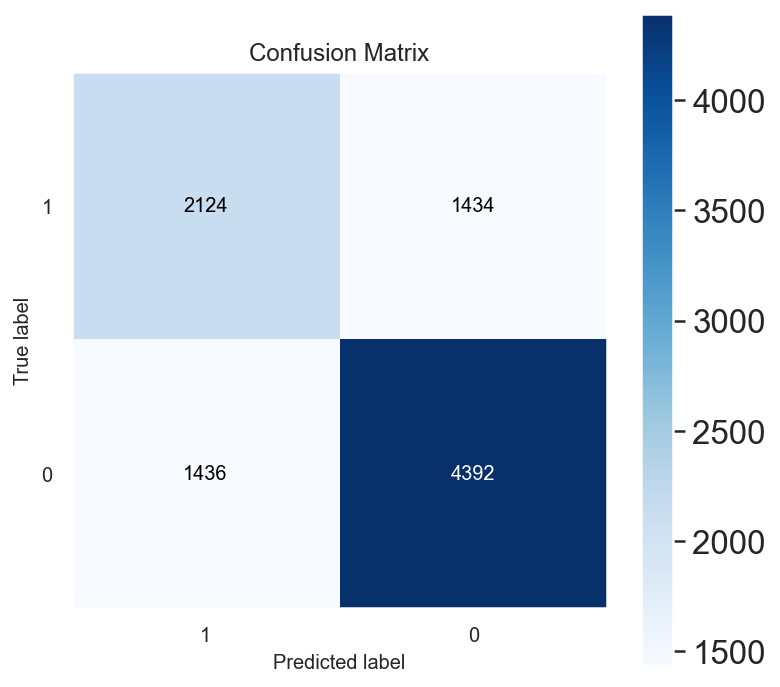

In [50]:
skplt.metrics.plot_confusion_matrix(y5_test, predictions, labels=[1, 0], figsize=(6, 6))
plt.show()

In [51]:
print(classification_report(y5_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5828
           1       0.60      0.60      0.60      3558

    accuracy                           0.69      9386
   macro avg       0.68      0.68      0.68      9386
weighted avg       0.69      0.69      0.69      9386



Precision is the ratio between the True Positives and all the Positives. In problem presented here,  it is the measure of tree that are correctly identified as deteriorated out of all the trees classified as deteriorated. In other words, precision shows what proportion of positive class were actually positive. In modele presented here its 75 % in class 0 and 60 % in class 1 .

The recall is the measure of the model correctly identifying True Positives. For all the trees which actually were deteriorated, recall tells us how many we correctly identified as being deteriorated. Recall in here is 0.75 for low class - healthy tree and 0.60 for high class - deteriorating tree, meaning 75 % and 60 % of samples were correctly identified.


Accuracy is the ratio of the total number of correct predictions and the total number of predictions. In this model its 69%, therefore the missclassification rate is 0.31 - 31%, which explains some of the unexpected results. 

In this dataset, I would consider achieving a high recall more important than getting a high precision – The aim is to detect as many deteriorated trees as possible.

F1 score is a harmonic man of precision and recall, that sometimes is taken into concideration instead of trying to find balance between precision and recall. Higher F1 score, better precision and recall.

In [52]:
probabilities_train = best_model.predict_proba(X5_train)
probabilities_test = best_model.predict_proba(X5_test)

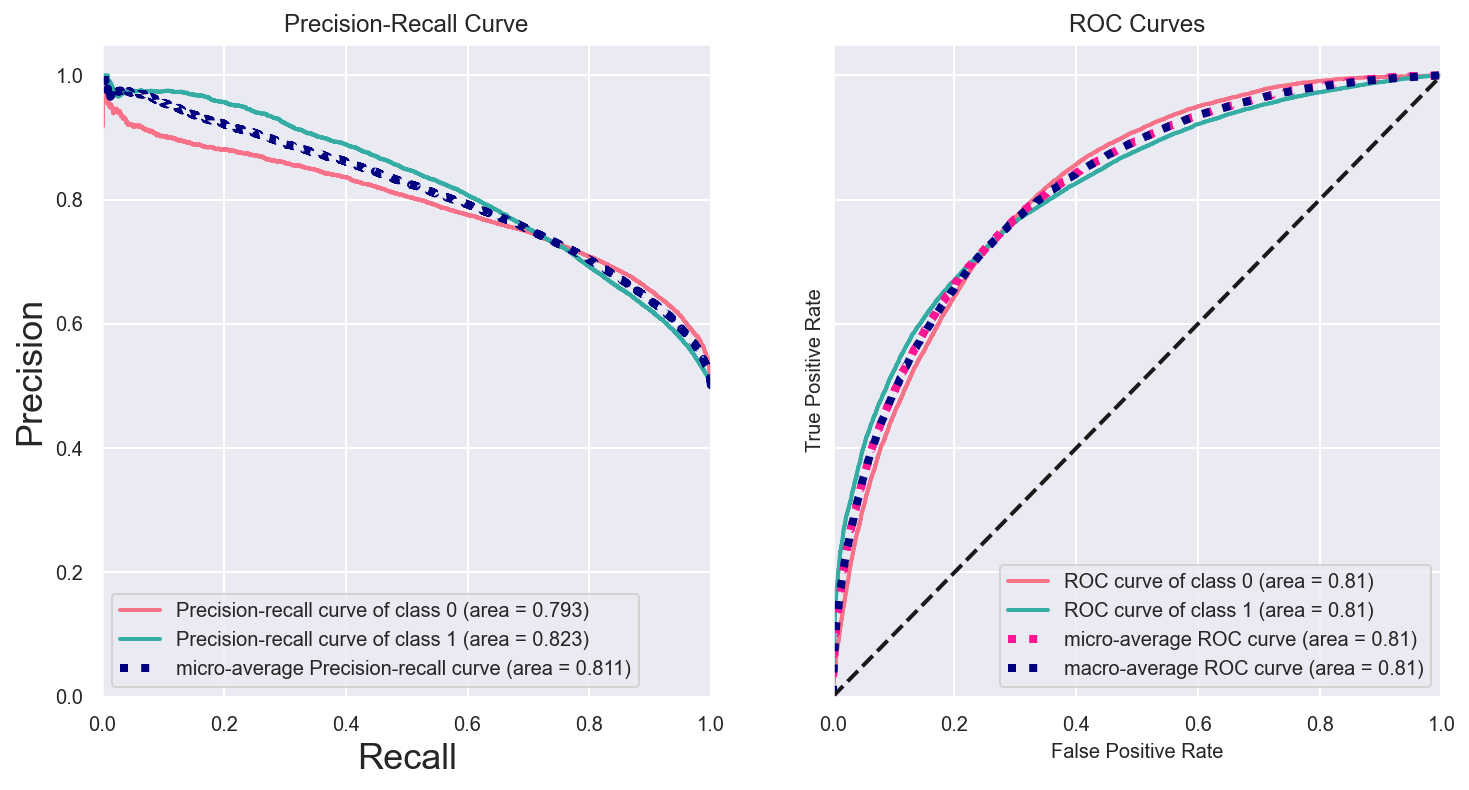

In [55]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
cmap = ListedColormap(sns.color_palette("husl", len(best_model.classes_)))
skplt.metrics.plot_precision_recall(y5_train, probabilities_train, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y5_train, probabilities_train, cmap=cmap, ax = ax[1])
plt.show()

This Precission recall curve shows the trade off between precission and recall for different threshold. It measures how successfull prediction is when classes are very imbalanced. A high area under the curve represents both high recall and high precission, where high precission indicate a low false positive rate and a high recall indicate low false negative rate. The graph shows very high AUC scores, confirming the model can be trusted in predicting tree condition based on the majority of the predictors chosen for the model.

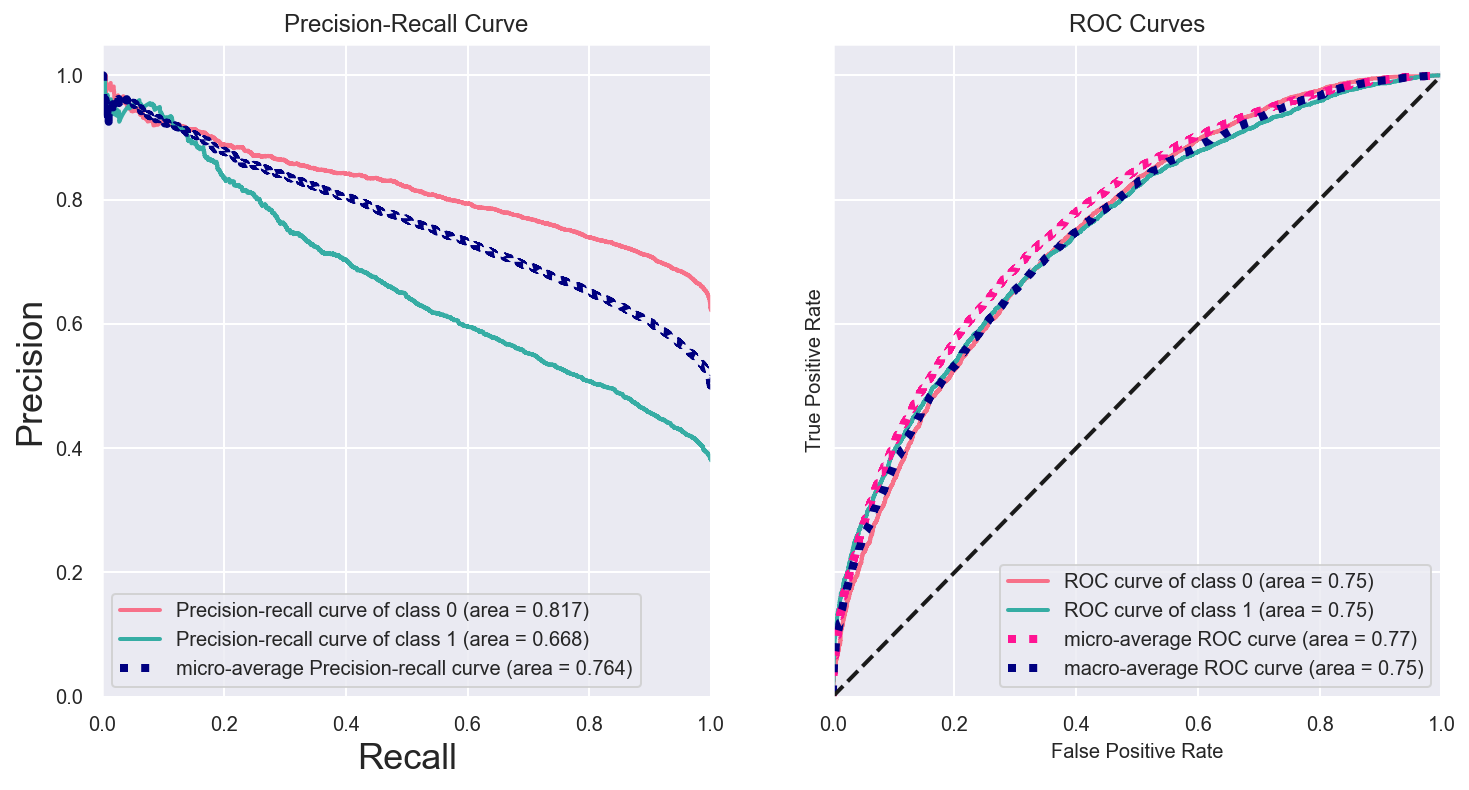

In [57]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
skplt.metrics.plot_precision_recall(y5_test, probabilities_test, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y5_test, probabilities_test, cmap=cmap, ax = ax[1])
plt.show()

The receiver operating characteristic curve is another evaluation tool to see the performance of binary classification algorithms. It provides a graphical overal representation of classifier as a whole rather than a single value. 
Similary like with the graph above, the higher area under the curve, higher AUC score the better classifier performs. 

ROC AUC takes into account TPR and FPR:
Recall/TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
so it multiplies TPR and FPR at each threshold. The score displayed on the graph its the sum of scores at each threshold. 

A perfect classifier will have a ROC AUC equal to 1. If the TPR is 1, the area under the curve is 1 (it cannot be larger), this is equivalent to perfect prediction.
Higher the ROC AUC, the better prediction aka the performance of the model at distinguishing between the positive and negative classes. In model presented, ROC AUC of 0.75 means the model correctly predicted 75% of the observations.

In [62]:
# saving the model to pickle 
import pickle 
pickle_out = open("tree_classifier1.pkl", mode = "wb") 
pickle.dump(best_model, pickle_out) 
pickle_out.close()

In [59]:
pickle_in = open('tree_classifier.pkl', 'rb') 
tree_classifier = pickle.load(pickle_in)

In [61]:
tree_classifier.coef_

array([[-3.50365524e-01,  2.29910878e-03,  1.13569299e+00,
         1.63977215e-01, -1.63252413e-01,  6.11738158e-02,
         1.87092810e-02, -3.88707489e-01, -1.30015684e-01,
        -3.11819491e-01, -1.77874423e-01, -1.24949511e-01,
         2.72096530e-01, -3.03138180e-01, -5.53777862e-01,
        -1.38103449e-01,  1.30983290e-01,  5.64194980e-02,
        -1.81938994e-01,  4.65346432e-02,  2.45269437e-02,
        -1.02514211e-01, -6.35034398e-02, -4.24890236e-02,
         3.24417696e-04, -2.02362799e-01, -2.35010900e-01,
        -1.05472929e-01, -1.64458230e-01, -1.30156706e-01,
         4.81034304e-02, -2.35010900e-01, -6.32525826e-02,
        -6.00097512e-02, -4.20434885e-02, -5.60699122e-03,
        -2.35010900e-01, -5.48382830e-02,  8.65528097e-02,
         1.08772183e-01,  1.80970164e-01, -3.75892126e-02,
         5.92799312e-03,  3.05174402e-02, -4.86257719e-01,
        -4.02181885e-01, -2.57215016e-01, -3.96191212e-02,
        -8.36563457e-02, -7.05226847e-02, -6.86516793e-0